In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

### Load Frames

In [3]:
def load_video_frames(path, color=False):
    vid = cv2.VideoCapture(path)
    frames = []
    while vid.isOpened():
        ret, frame = vid.read()
        if not ret:
            break

        conversion = cv2.COLOR_BGR2RGB if color else cv2.COLOR_BGR2GRAY
        frame = cv2.cvtColor(frame, conversion)
        frames.append(frame)
    
    vid.release()
    return np.array(frames)

color_frames = load_video_frames("cropped_cat_video.mp4", color=True)
frames = load_video_frames("cropped_cat_video.mp4")


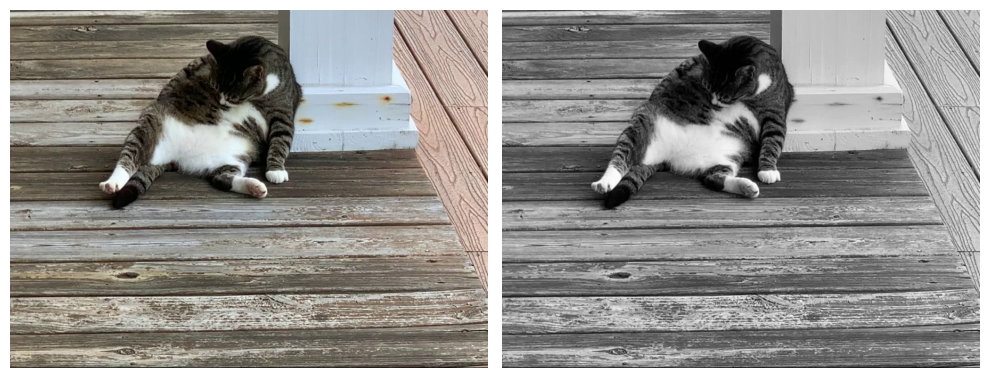

In [4]:
def show_frames(*frames):
    for i, f in enumerate(frames):
        plt.subplot(np.ceil(len(frames) / 2).astype(int), 2, i+1)
        plt.imshow(f, cmap="gray")
        plt.axis("off")
    plt.gcf().set_figwidth(10)
    plt.gcf().set_figheight(7.5)
    plt.tight_layout()
    plt.show()

show_frames(color_frames[0], frames[0])

### Image Gradient

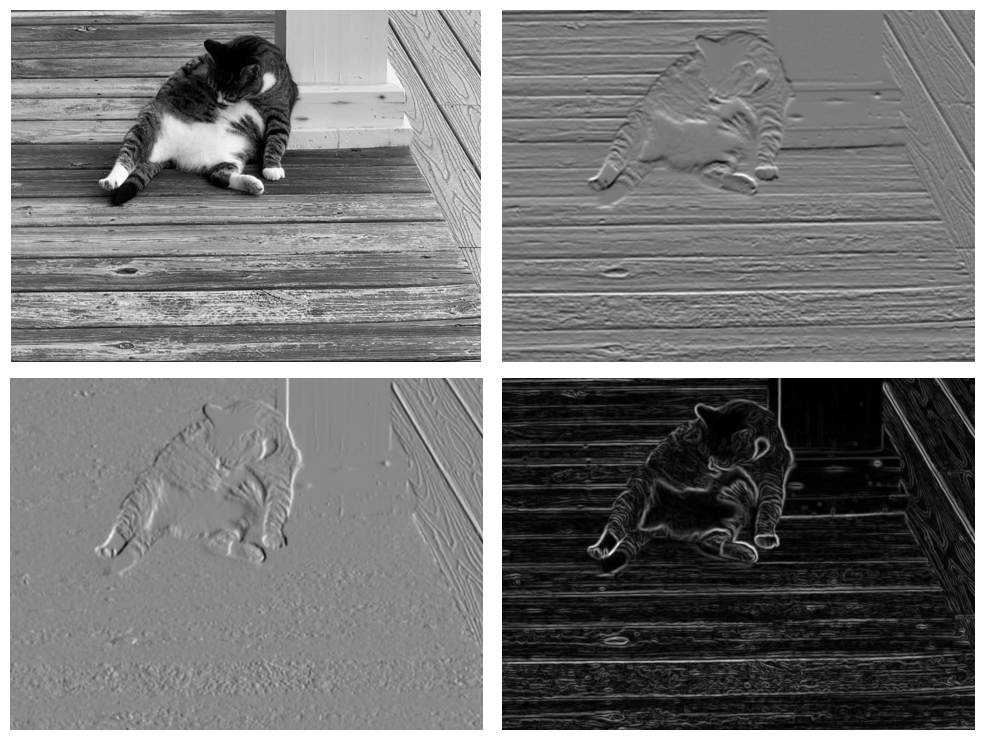

In [196]:
def row(vector):
    return vector.reshape(1, -1)

def col(vector):
    return vector.reshape(-1, 1)

# function to convert sigma <--> h for kernels
def truncate(sigma=None, h=None):
    assert (sigma is not None) or (h is not None), "Must provide either sigma or h"
    if sigma is None:
        sigma = h / 3.5
    elif h is None:
        h = np.ceil(3.5 * sigma)
    return sigma, h
    

def gaussian_kernel(sigma=None, h=None):
    sigma, h = truncate(sigma, h)
    x = np.arange(-h, h + 1, 1)
    # ignore constant in front and normalize after
    kernel = np.exp(-0.5*(x / sigma)**2)
    norm_factor = np.convolve(np.ones_like(kernel), kernel, mode="valid")[0]
    kernel /= norm_factor

    # plt.plot(x, kernel)
    return kernel


def deriv_kernel(sigma=None, h=None):
    # get derivative of gaussian
    sigma, h = truncate(sigma, h)
    x = np.arange(-h, h + 1, 1)
    # ignore constant in front because will rescale anyways
    kernel = -x * np.exp(-0.5*(x / sigma)**2)

    # normalize so derivative on a unit ramp is correct
    unit_ramp = x  # by coincidence, we already made a unit ramp of the correct shape
    norm_factor = np.convolve(unit_ramp, kernel, mode="valid")[0]
    kernel /= norm_factor

    # plt.plot(x, kernel)
    return kernel


def image_gradient(frame, sigma=None, h=None):
    d = deriv_kernel(sigma, h)
    g = gaussian_kernel(sigma, h)
    # smooth in one direction and differentiate in the other
    vert_deriv = convolve2d(convolve2d(frame, col(d), mode="valid"), row(g), mode="valid")
    horiz_deriv = convolve2d(convolve2d(frame, row(d), mode="valid"), col(g), mode="valid")
    return np.stack((vert_deriv, horiz_deriv), axis=0)

grad = image_gradient(frames[0], sigma=2)
grad_mag = np.linalg.norm(grad, axis=0)
show_frames(frames[0], grad[0], grad[1], grad_mag)


### Features to Track

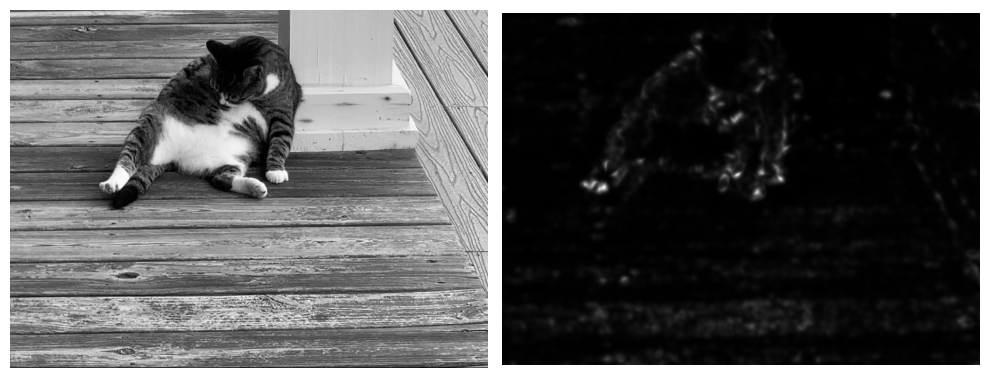

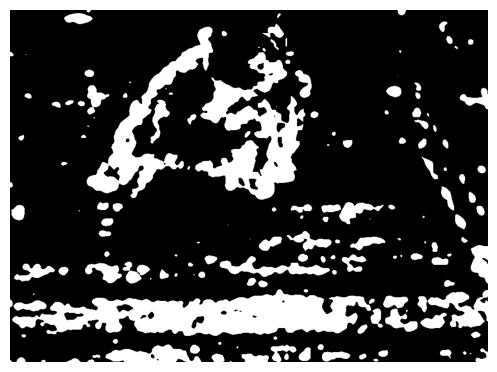

In [197]:
def get_matrix_A_elements(gradient, window_size):
    g_00 = gradient[0] ** 2
    g_01 = gradient[0] * gradient[1]
    g_11 = gradient[1] ** 2

    # convolve with window to get the 3 distinct elements of matrix A for each pixel
    # 3 not 4 because A is symmetric
    # do each element in two steps to exploit separability
    h = (window_size - 1) / 2
    w = gaussian_kernel(h=h)
    row_w = row(w)
    col_w = col(w)
    a_00 = convolve2d(convolve2d(g_00, row_w, "valid"), col_w, "valid")
    a_01 = convolve2d(convolve2d(g_01, row_w, "valid"), col_w, "valid")
    a_11 = convolve2d(convolve2d(g_11, row_w, "valid"), col_w, "valid")

    return a_00, a_01, a_11


def smaller_eigenvalues(frame, window_size=31):
    assert window_size % 2 == 1, "Window size should be an odd number"

    grad = image_gradient(frame, sigma=2)    
    a_00, a_01, a_11 = get_matrix_A_elements(grad, window_size)

    # use quadratic formula to solve for smaller eigenvalue
    # get b and c coefs for quadratic formula, a is 1
    b = - (a_00 + a_11)
    c = a_00*a_11 - a_01**2
    discrim = np.sqrt(np.maximum(0., b**2 - 4*c))  # max with 0 in case floating point error gives us barely negative numbers
    smaller_eigen = (-b - discrim) / 2
    return smaller_eigen


min_e  = smaller_eigenvalues(frames[0])
show_frames(frames[0], min_e)
show_frames(min_e > 5)

0.3366701602935791
0.35170674324035645
0.5788173675537109
Found 200 features!


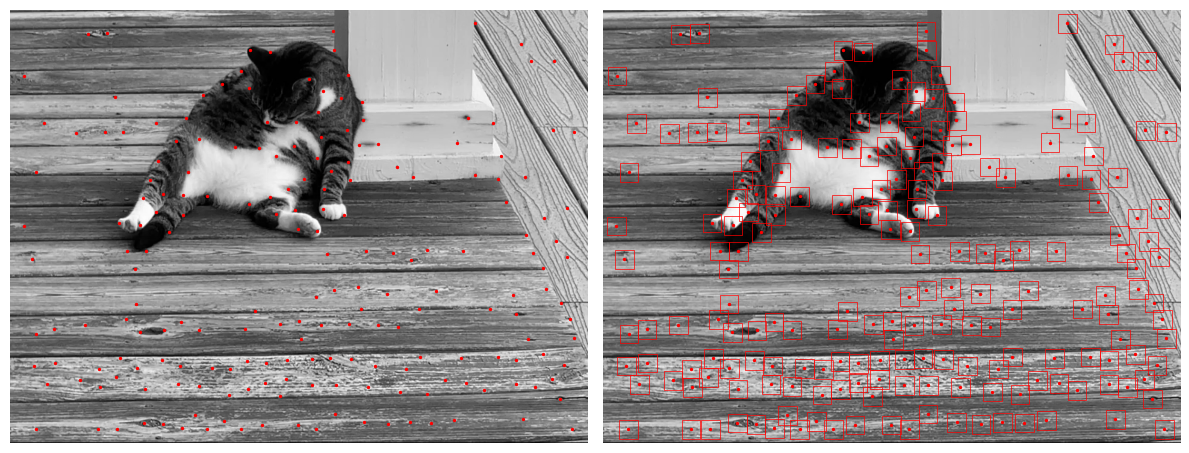

In [117]:
from matplotlib.patches import Rectangle
import time
from scipy.ndimage import zoom


def features_to_track(frame, max_n=200, window_size=31, radius=None, small_eig_threshold=5):
    assert window_size % 2 == 1, "Window size should be an odd number"
    t0 = time.time()

    if radius is None:
        radius = window_size
    small_eigs = smaller_eigenvalues(frame, window_size)

    print(time.time() - t0)

    # get indices of locations we have small eigs for
    # this is a smaller region than the image b/c we used valid convolutions
    offset = (frame.shape[0] - small_eigs.shape[0]) // 2
    r, c = np.indices(small_eigs.shape) + offset
    eigs_and_indices = np.dstack((small_eigs, r, c)).reshape(-1, 3)

    # remove pixels failing the small eigenvalue threshold
    meet_threshold = eigs_and_indices[:, 0] >= small_eig_threshold
    eigs_and_indices = eigs_and_indices[meet_threshold]

    # sort by eigenvalue
    sort_indices = np.argsort(-eigs_and_indices[:, 0])
    eigs_and_indices = eigs_and_indices[sort_indices]

    print(time.time() - t0)

    # use non-max suppression to choose features to track
    features = []
    for _ in range(max_n):
        if eigs_and_indices.shape[0] == 0:
            break
        pixel = eigs_and_indices[0, 1:]
        features.append(pixel)
        # remove pixels close to this feature
        sq_dist = np.sum((eigs_and_indices[:, 1:] - pixel)**2, axis=1)
        eigs_and_indices = eigs_and_indices[sq_dist > radius ** 2]

        # remove pixels in a square region around this feature - is a bit faster
        # deltas = np.abs(eigs_and_indices[:, 1:] - pixel)
        # keep_mask = (deltas[:,0] > radius) | (deltas[:,1] > radius)
        # eigs_and_indices = eigs_and_indices[keep_mask]

    print(time.time() - t0)

    return np.array(features)


def plot_features(frame, features, window_size):
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.axis("off")
        plt.imshow(frame, cmap="gray")
        plt.scatter(features[:, 1], features[:, 0], s=2, c="red")
    h = (window_size - 1) / 2
    for f in features:
        rect = Rectangle((f[1] - h, f[0] - h), window_size, window_size,
                        edgecolor="red", facecolor="none", linewidth=0.5)
        plt.gca().add_patch(rect)
    plt.gcf().set_figwidth(12)
    plt.tight_layout()


window_size = 31
features = features_to_track(frames[0], window_size=window_size)
print(f"Found {features.shape[0]} features!")
plot_features(frames[0], features, window_size)
plt.show()

### Tracking

center [333. 473.]


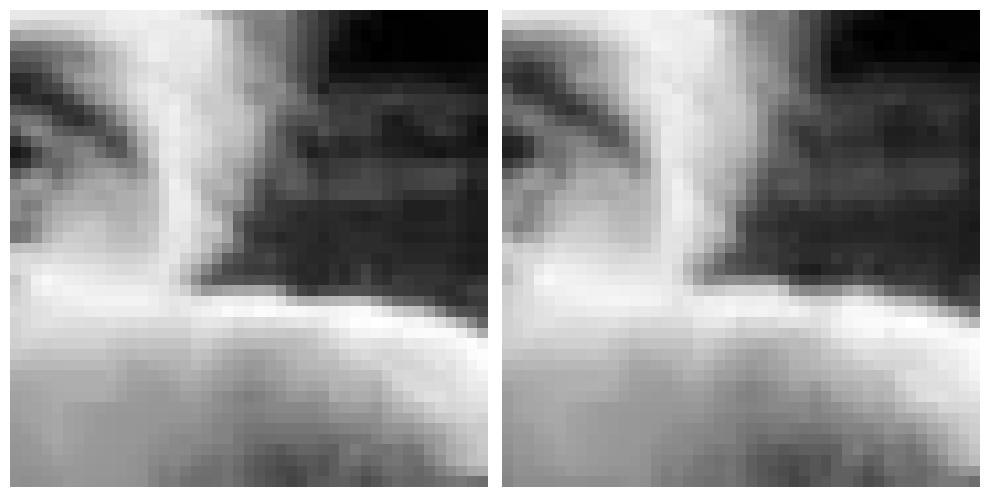

[[146.81618731 -11.12431449]
 [-11.12431449 137.09430238]]
[  822.92066447 -1935.61608239]
step [  4.56337393 -13.74857775] step size 14.486123423685397


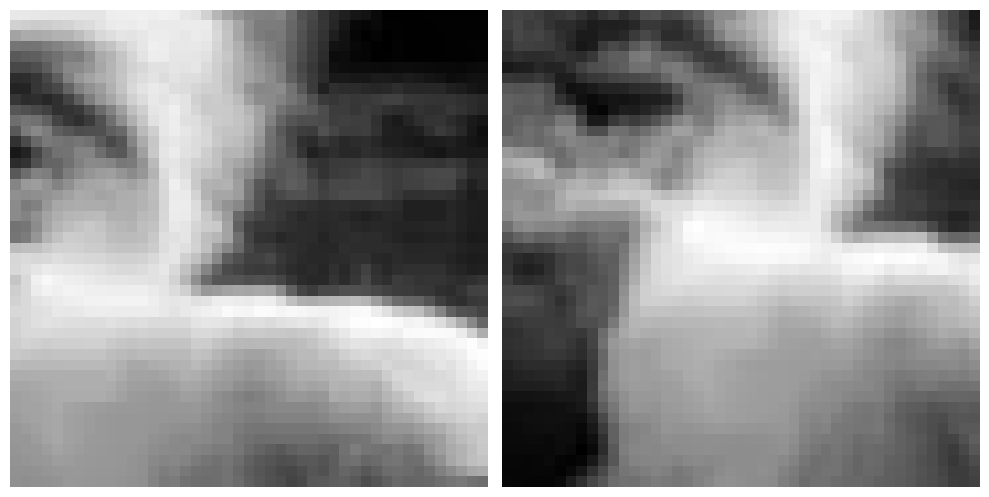

[[42.3817319   4.21899786]
 [ 4.21899786 17.89295507]]
[ -4.19696617 104.33914304]
step [-0.69585247  5.99537319] step size 6.035620129497625


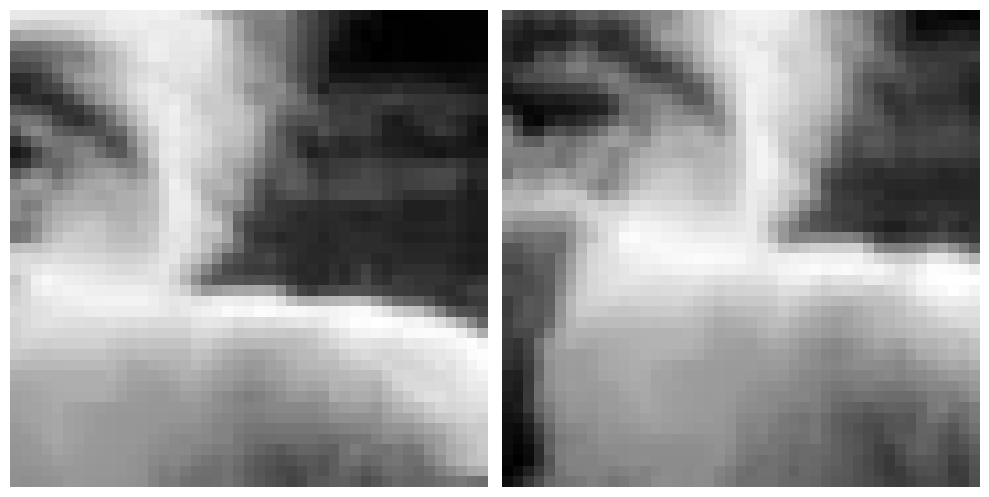

[[54.02030484 -4.5759735 ]
 [-4.5759735  37.53983654]]
[  87.1956176  -348.63805708]
step [ 0.83606007 -9.18523627] step size 9.223207785779255
Suggesting too big of a step, lost


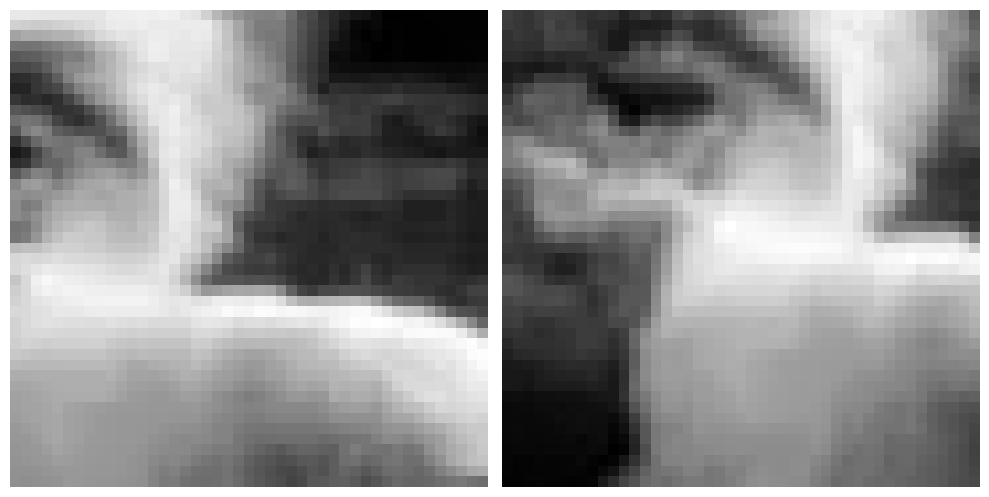

In [209]:
from scipy.ndimage import map_coordinates


def crop_margin(arr, margin):
    # removes margin from first two axes
    return arr[margin:-margin, margin:-margin]


def LK(frame0, frame1, frame0_point, d0=np.array([0, 0]), window_size=31, min_step_size=0.001, max_iter=100):
    assert window_size % 2 == 1, "Window size should be an odd number"
    # use shorter names
    f, g, xf = frame0, frame1, frame0_point
    print("center", xf)

    # TODO check if started outside image bounds

    d = d0
    
    # define window indices and use them to get the pixel values of the f window
    h = (window_size - 1) / 2
    margin = 7  # due to valid convolution when taking image gradient
    window_indices = np.indices(
        [window_size + 2*margin, window_size + 2*margin]) - (h + margin)
    # center on xf
    window_indices = window_indices + xf.reshape(-1, 1, 1)
    # get pixel values in first frame
    i = map_coordinates(f, window_indices)

    # from now on, we will use window indices to refer to the g window, update appropriately
    window_indices = window_indices + d.reshape(-1, 1, 1)

    gaussian = gaussian_kernel(h=h)
    window_weights = col(gaussian) * row(gaussian)

    # iterate
    converged = False
    for _ in range(max_iter):
        # get pixel values of shifted window w margin
        j = map_coordinates(g, window_indices)
        show_frames(i, j)

        # get gradient for all points in window
        grad = image_gradient(j, h=margin)

        # use that to get A and b
        A = np.zeros((2,2))
        A[0][0] = np.sum(grad[0] * grad[0] * window_weights)
        A[0][1] = np.sum(grad[0] * grad[1] * window_weights)
        A[1][0] = A[0][1]
        A[1][1] = np.sum(grad[1] * grad[1] * window_weights)

        diff = crop_margin(i, margin) - crop_margin(j, margin)
        b = np.zeros(2)
        b[0] = np.sum(grad[0] * diff * window_weights)
        b[1] = np.sum(grad[1] * diff * window_weights)

        print(A)
        print(b)

        # solve for the step
        step, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
        print("step", step, "step size", np.linalg.norm(step))

        # accumulate the step into the total displacement d
        d = d + step
        # update window indices with the step
        window_indices = window_indices + step.reshape(-1, 1, 1)

        # check if we're done
        if np.linalg.norm(step) < min_step_size:
            print("Converged!")
            converged = True
            break

        # check if we're lost, if so break the loop without flagging converged
        if np.linalg.norm(d - d0) > h:
            print("Suggesting too big of a step, lost")
            break
        # TODO check if left image g bounds

    
    show_frames(i, map_coordinates(g, window_indices))

    return d if converged else None


LK(frames[0], frames[1], features[0], d0=np.array([2, 1]))